## Build anndata from `cellatac` output

In this notebook we put together the many outputs of the [cellatac pipeline](https://github.com/cellgeni/cellatac) for peak calling in scATAC-seq data into one handy anndata object, we do some important peak filtering

In [1]:
import numpy as np
import scipy.sparse
import pandas as pd 
import scanpy as sc

In [2]:
outdir = "/home/ubuntu/data/heart/scATACseq/cellatac/regions/LV-results200k/"
experiment_prefix = 'hca_heart_LV'
cellatac_outdir = '/home/ubuntu/data/heart/scATACseq/cellatac/regions/LV-results200k/'

In [3]:
input={'cnts': cellatac_outdir + 'peak_matrix/peaks_bc_matrix.mmtx.gz',
        "bcs": cellatac_outdir + 'peak_matrix/bc.txt',
      "peaks": cellatac_outdir + 'peak_matrix/peaks.txt',
      'clusters': cellatac_outdir + 'qc/seurat-clades.tsv'}

output = {
    "cnt_mmtx":outdir + experiment_prefix + '_ATAC_cisTopic.mmtx',
    "cnt_peaks":outdir + experiment_prefix + '_ATAC_cisTopic.peaks.tsv',
    "cnt_cells":outdir + experiment_prefix + '_ATAC_cisTopic.cells.tsv',
    "h5ad":outdir + experiment_prefix + '_ATAC_raw.h5ad',
}

### Make anndata object

In [4]:
adata = sc.read_mtx(input["cnts"]).T

bc = pd.read_table(input["bcs"], header = None)
feat = pd.read_table(input["peaks"], header = None)

adata.obs_names = bc[0]
adata.var_names = feat[0]

### Load peak annotations computed with `annotate_peaks.R`

In [5]:
peak_anno_df = pd.read_csv(outdir + "ATACpeaks_annotation.csv", index_col = 0)
peak_anno_df.index = peak_anno_df["peak_id"]
peak_anno_df.drop("peak_id",1, inplace = True)
adata.var = pd.concat([adata.var, peak_anno_df], 1)
adata

AnnData object with n_obs × n_vars = 10447 × 290513
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist'

### Save binary data to layers

In [6]:
adata.layers["binary_raw"] = adata.X
adata.layers["binary_raw"][adata.layers["binary_raw"] > 1] = 1
adata

AnnData object with n_obs × n_vars = 10447 × 290513
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist'
    layers: 'binary_raw'

### Peak filtering

`cellatac` calls a lot of peaks that are just noisy and downsizing the matrix a bit makes everything faster.

#### OBS: Check the filters for your data carefully so you don't throw away usueful info.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe815ebf610>]],
      dtype=object)

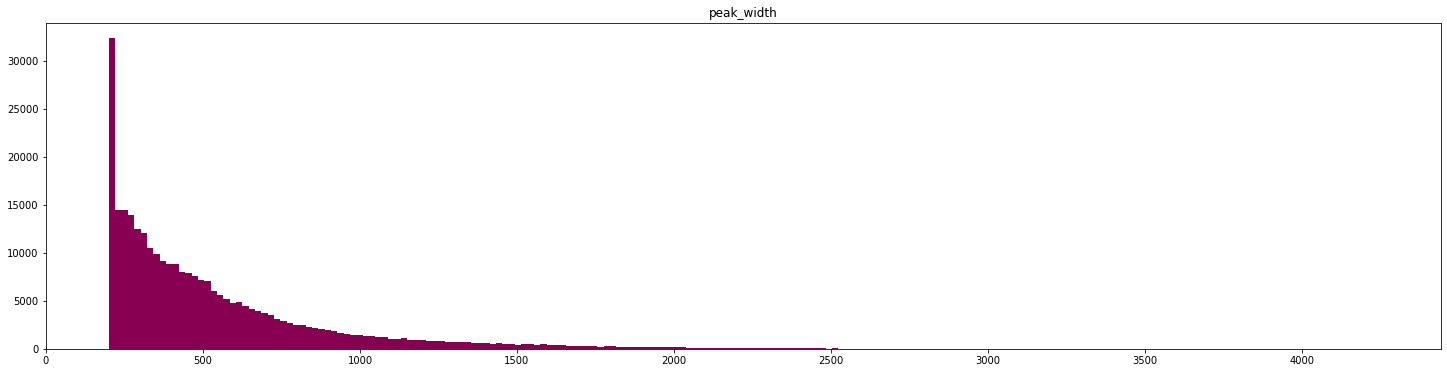

In [8]:
adata.var.hist(column = 'peak_width', bins = 200, grid = False, figsize = (25,6), color = '#870052')

### Preliminary filtering

- Basic QC

In [9]:
var_qc = sc.pp.calculate_qc_metrics(adata, layer = "binary_raw")[1]
adata.var = pd.concat([adata.var, var_qc], 1)
adata

AnnData object with n_obs × n_vars = 10447 × 290513
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

- Remove cells with peaks accessible in less than k cells

In [10]:
adata.var.head()

,peak_width,exon,gene,promoter,annotation,gene_name,gene_id,tss_distance,ENCODE_blacklist,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
peak_id,,,,,,,,,,,,,,,
chr1:180719-181587,869,0,0,1,promoter,FO538757.2,ENSG00000279928,805,1,652,0.062410,0.060540,93.758974,652.0,6.481577
chr1:184065-184544,480,1,1,0,exon,FO538757.2,ENSG00000279928,1671,1,143,0.013688,0.013595,98.631186,143.0,4.969813
chr1:191296-191630,335,0,1,0,intron,FO538757.1,ENSG00000279457,3780,1,253,0.024217,0.023929,97.578252,253.0,5.537334
chr1:267871-268081,211,0,0,0,intergenic,NaN,NaN,67548,1,187,0.017900,0.017742,98.210012,187.0,5.236442
chr1:586080-586280,201,0,0,0,intergenic,NaN,NaN,100373,1,163,0.015603,0.015482,98.439743,163.0,5.099866


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe869b34df0>]],
      dtype=object)

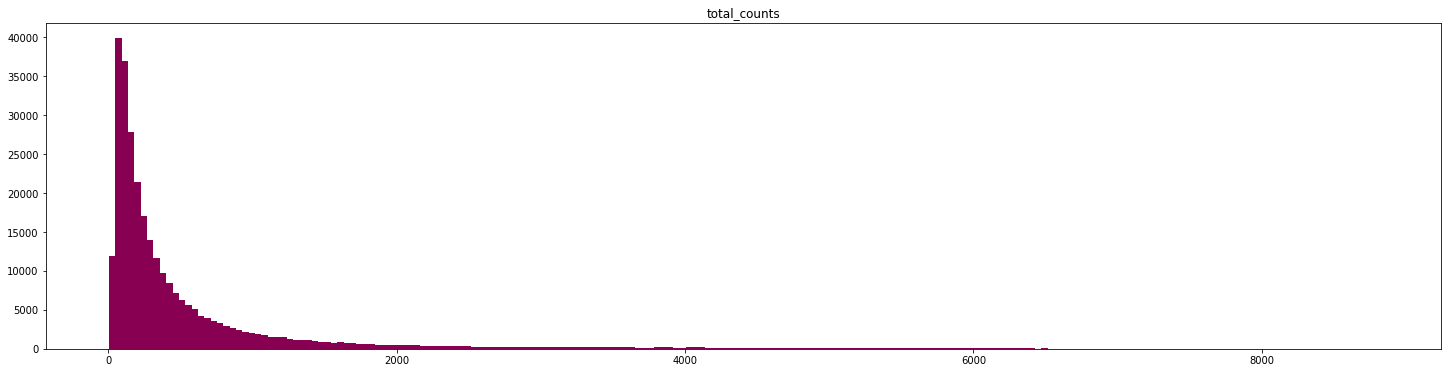

In [11]:
adata.var.hist(column = 'total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [12]:
adata = adata[:,adata.var.total_counts > 30]
adata = adata[:,adata.var.total_counts < 1500]
adata

View of AnnData object with n_obs × n_vars = 10447 × 262489
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

- Remove peaks in ENCODE blacklist

In [13]:
adata = adata[:, adata.var.ENCODE_blacklist == 0]
adata

View of AnnData object with n_obs × n_vars = 10447 × 261459
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

- Filter by width (remove peaks at the lowest end, closest to min peak width in MACS2)

In [14]:
adata = adata[:, adata.var.peak_width > 210]
adata = adata[:, adata.var.peak_width < 1500]
adata

View of AnnData object with n_obs × n_vars = 10447 × 238879
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

- Filter peaks that are not accessible in at least 10% of cells from a coarse cluster

In [15]:
min_frac = 0.1

- Load cluster information from cellatac outputs

In [16]:
clusters = pd.read_table(input["clusters"], header = None, index_col = 0)
clusters.columns = ["cellatac_clusters"]
adata.obs = clusters.loc[adata.obs_names]
adata

AnnData object with n_obs × n_vars = 10447 × 238879
    obs: 'cellatac_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

- Add cluster matrix

In [17]:
n_clusters = len(np.unique(adata.obs[["cellatac_clusters"]]))
clus_mat = np.empty([adata.n_obs, n_clusters])
for cl in np.unique(adata.obs[["cellatac_clusters"]]):
    clus_mat[np.where(adata.obs['cellatac_clusters']==cl)[0],cl] = 1

clus_mat = scipy.sparse.csr_matrix(clus_mat)
clus_mat[clus_mat != 1 ] = 0

/home/ubuntu/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: SparseEfficiencyWarning: Comparing a sparse matrix with a nonzero scalar using != is inefficient, try using == instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
cl_peak_mat = np.dot(clus_mat.T, adata.layers["binary_raw"])

In [19]:
cl_peak_frac = cl_peak_mat/clus_mat.sum(0).T

In [20]:
adata = adata[:, cl_peak_frac.max(0) > min_frac]
adata

### Filter low quality cells

In [22]:
sc.pp.calculate_qc_metrics(adata, layer = "binary_raw", inplace = True)

Trying to set attribute `.obs` of view, copying.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8100c7f70>]],
      dtype=object)

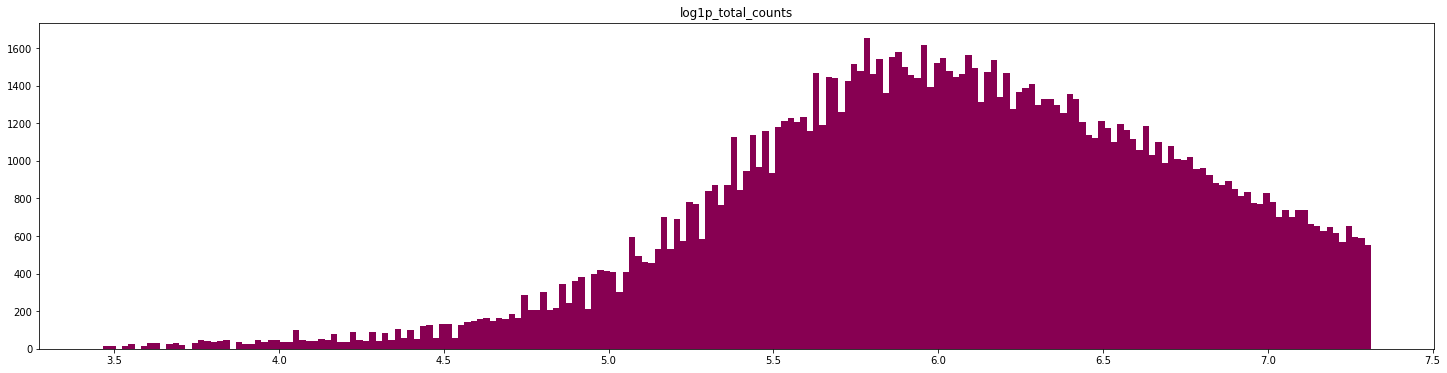

In [23]:
adata.var.hist(column = 'log1p_total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [24]:
adata = adata[adata.obs.log1p_total_counts >= 5.5]
adata

View of AnnData object with n_obs × n_vars = 10145 × 135228
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

### Write output anndata

In [25]:
adata.write(output["h5ad"])

/home/ubuntu/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 'annotation' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'gene_name' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'gene_id' as categorical
